In [9]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.morningstar import Fundamentals as Fundamentals_m
from quantopian.pipeline.domain import US_EQUITIES
from quantopian.research import run_pipeline
from quantopian.research import prices
import alphalens as al
from alphalens.tears import create_returns_tear_sheet
from alphalens.tears import create_information_tear_sheet
from quantopian.pipeline.data import factset
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

In [23]:
def make_pipeline():
    
    enterprise_value = Fundamentals_m.enterprise_value.latest # Winner Secure
    enterprise_value = enterprise_value.winsorize(min_percentile=0.05, max_percentile=0.95)
    universe = QTradableStocksUS()
    
    combined_factor = (
        enterprise_value.zscore()
    )

    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe

Dropped 2.2% entries from factor data: 2.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.014,0.034,0.046
IC Std.,0.169,0.162,0.161
Risk-Adjusted IC,0.081,0.209,0.284
t-stat(IC),1.797,4.642,6.298
p-value(IC),0.073,0.000,0.000
IC Skew,0.030,-0.204,-0.268
IC Kurtosis,-0.184,-0.391,-0.450


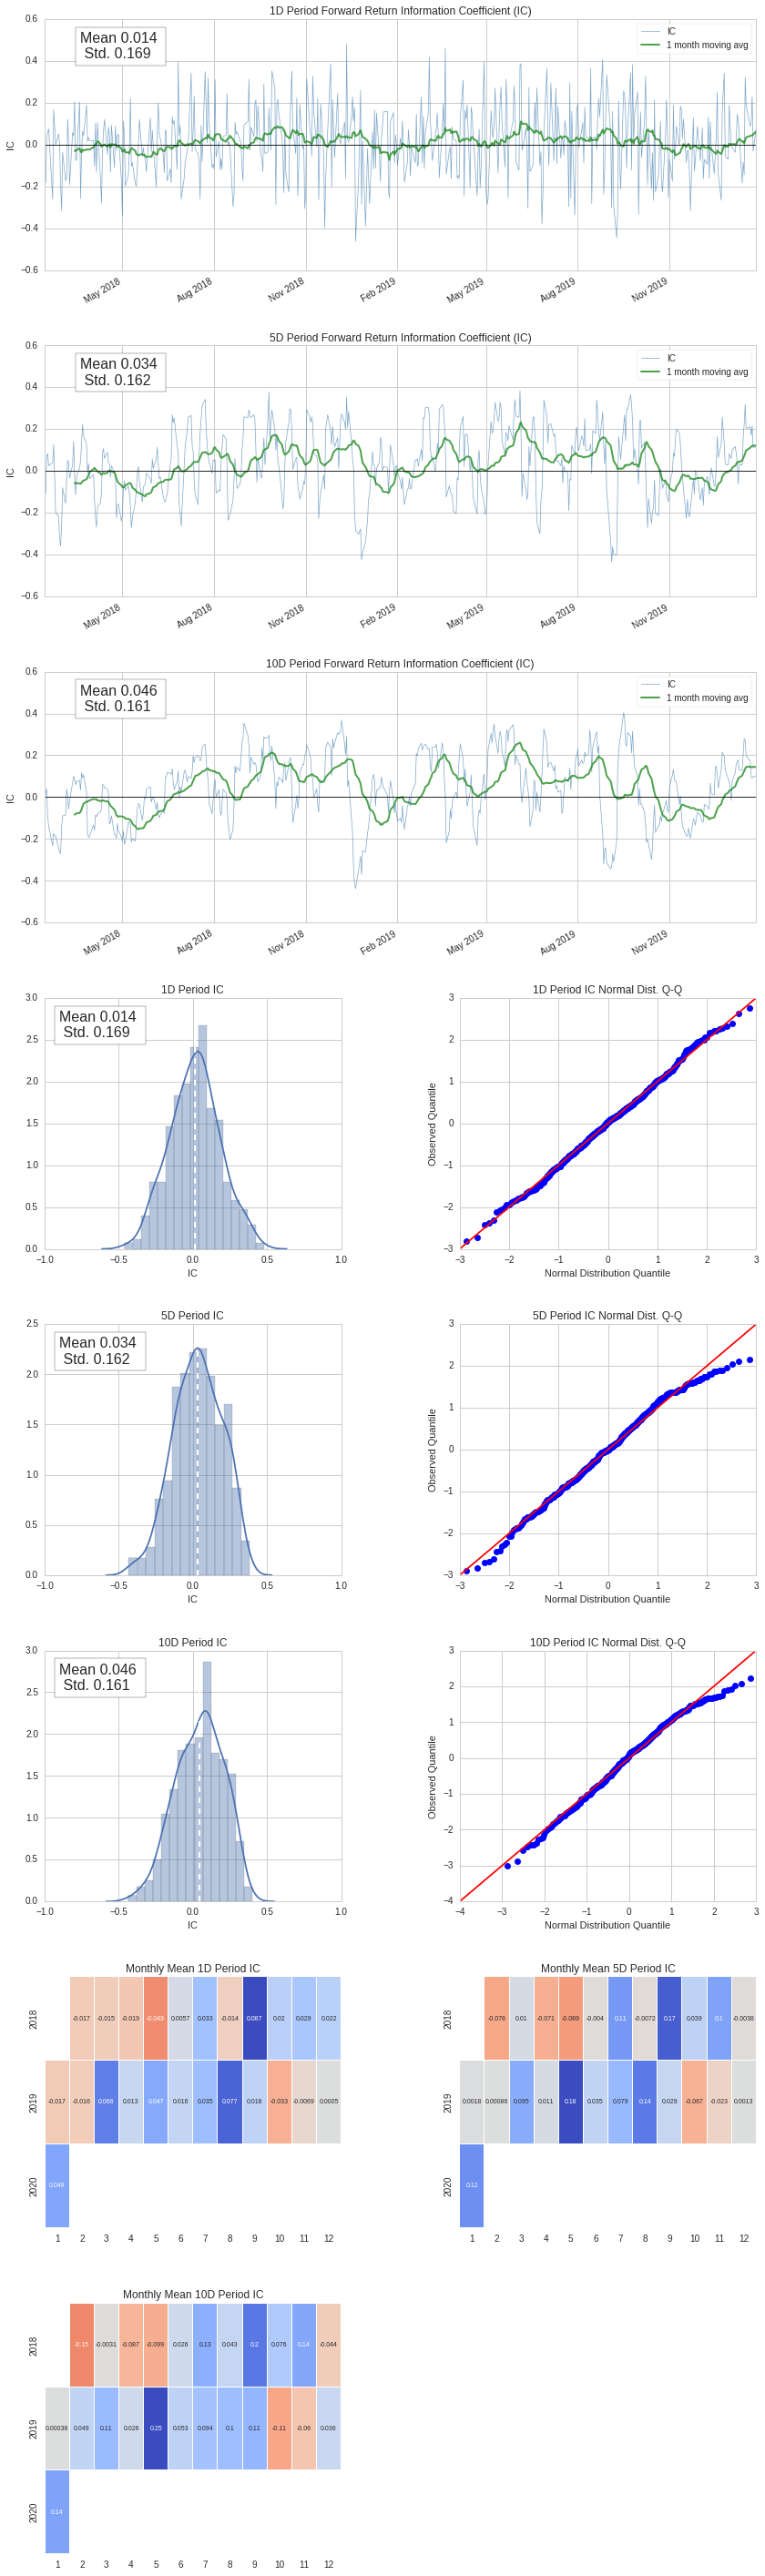

In [24]:
today = "2/11/2020"
two_years_before="2/11/2018"

pipeline_output = run_pipeline(
    make_pipeline(),
    start_date= two_years_before,
    end_date=today
)

asset_list = pipeline_output.index.levels[1].unique()
asset_prices = prices(
    asset_list,
    start=two_years_before,
    end=today
)
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)
create_information_tear_sheet(factor_data)

Returns Analysis


,1D,5D,10D
Ann. alpha,0.049,0.054,0.057
beta,-0.224,-0.257,-0.279
Mean Period Wise Return Top Quantile (bps),1.076,1.333,1.357
Mean Period Wise Return Bottom Quantile (bps),-1.074,-1.332,-1.357
Mean Period Wise Spread (bps),2.150,2.665,2.714


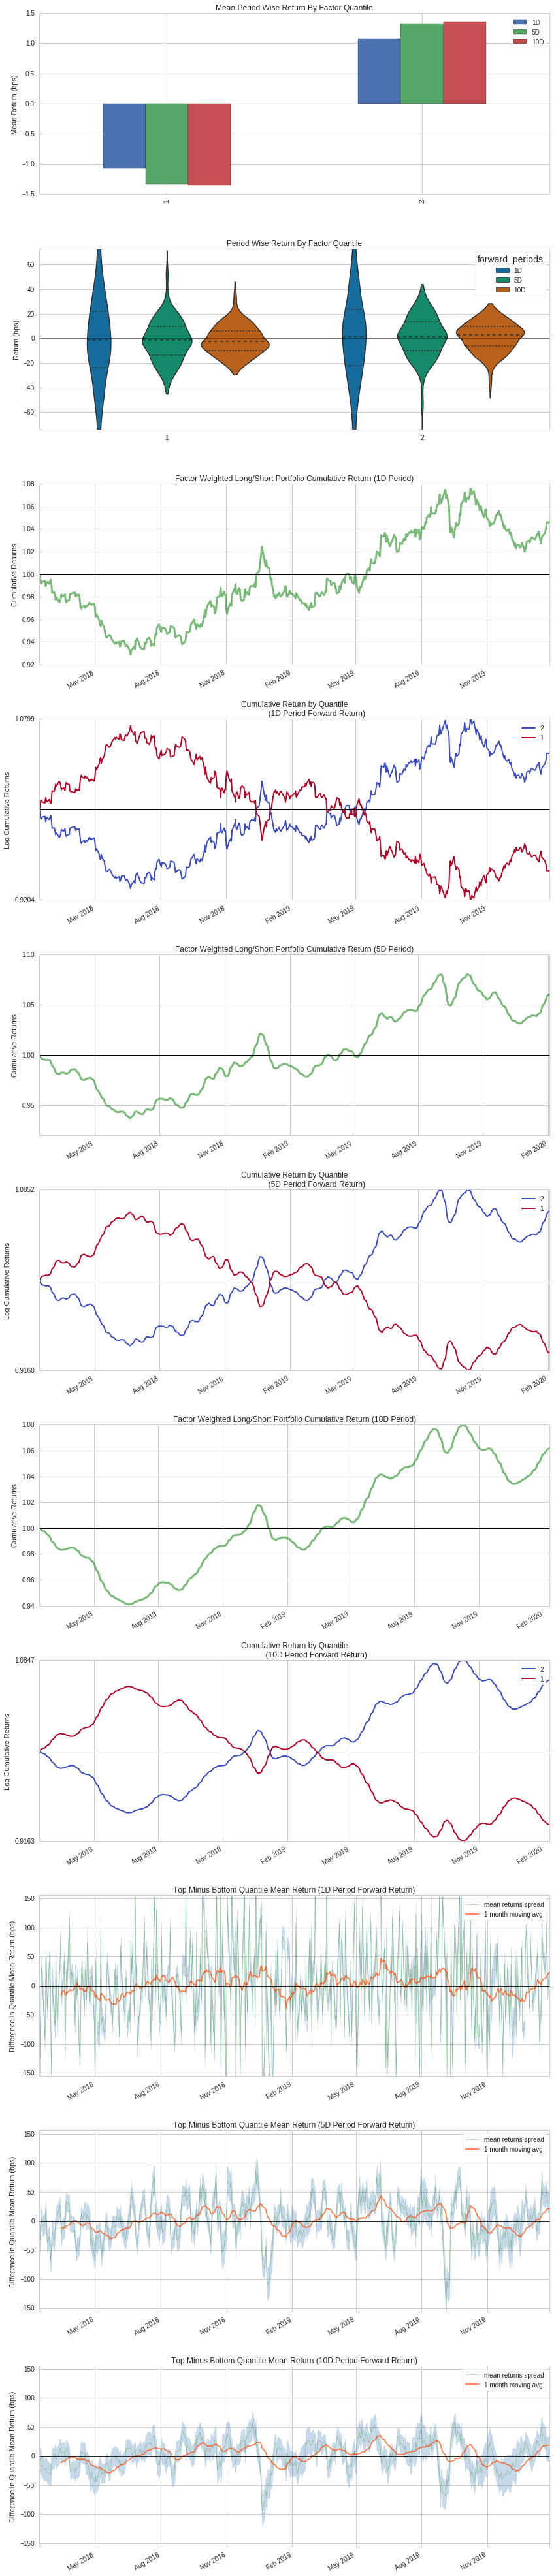

In [25]:
create_returns_tear_sheet(factor_data)